In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import random

from src.data_loader import load_fruit_images
from src.show_images import show_images
from src.center_crop_resize import center_crop_and_resize
from src.show_random_image import plot_random_images
from src.predict_by_color_channel import channel_prediction
from src.test_channel_thresh import find_best_threshold
from src.test_channel_ratio_thresh import find_best_ratio_thresh
from src.evaluation import calculate_metrics
from src.channel_to_channel_ratio import channel_ratio_classifier

## Load the images
- Images starting with 'a' are apples.
- Images starting with 'b' are bananas.

In [2]:
folder_path = "/mnt/e/Term 3/Machin-Learning/Projects/01 pro/data/images"
apple_images, banana_images = load_fruit_images(folder_path)

print(f"Number of apple images: {len(apple_images)}")
print(f"Number of banana images: {len(banana_images)}")


Number of apple images: 32
Number of banana images: 30


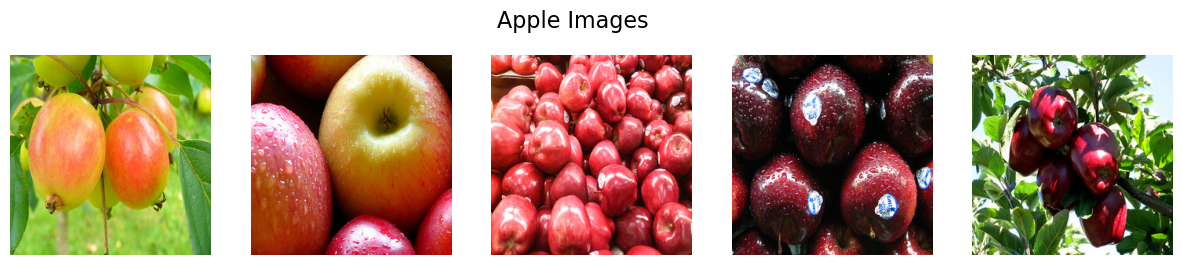

In [3]:
show_images(apple_images, title="Apple Images", max_images=5)

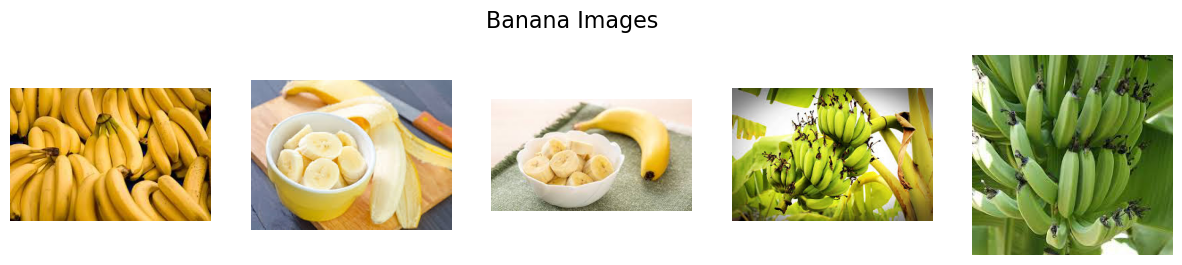

In [4]:
show_images(banana_images, title="Banana Images", max_images=5)

we observe that apple images have equal size but banana images have different sizes. To find all of the sizes with iterate over the images and add any new size to a hashset. 

First we do this for apple images to make sure they are equal in size:

In [5]:
different_sizes = dict()
for image in apple_images:
    different_sizes[image.shape] = different_sizes.get(image.shape, 0) + 1
different_sizes

{(256, 256, 3): 32}

We see that all apple images have (256, 256, 3) size. Now we do this for banana images:

In [6]:
different_sizes = dict()
for image in banana_images:
    different_sizes[image.shape] = different_sizes.get(image.shape, 0) + 1
different_sizes

{(183, 275, 3): 4,
 (194, 259, 3): 2,
 (168, 300, 3): 4,
 (225, 225, 3): 7,
 (195, 259, 3): 2,
 (163, 310, 3): 1,
 (259, 194, 3): 1,
 (168, 299, 3): 1,
 (173, 292, 3): 1,
 (198, 254, 3): 1,
 (194, 260, 3): 1,
 (162, 311, 3): 1,
 (182, 277, 3): 1,
 (170, 297, 3): 1,
 (177, 285, 3): 1,
 (174, 290, 3): 1}

We see that banana images have different sizes and aspect ratios. The most frequent size is (225, 225, 3) which has an aspect ratio of 1:1, just as the apple images. 

Observing the banana images, we notice that in the majority of images the bananas are placed at the center of the image. As a result, we can center crop the images with an aspect ratio of 1:1 and then convert the images to (256, 256, 3), which is the size of apple images.

To do this, we write a function to center crop and resize a list of images:

In [7]:
banana_resized_images = center_crop_and_resize(banana_images)

In [8]:
different_sizes = dict()
for image in banana_resized_images:
    different_sizes[image.shape] = different_sizes.get(image.shape, 0) + 1
different_sizes

{(256, 256, 3): 30}

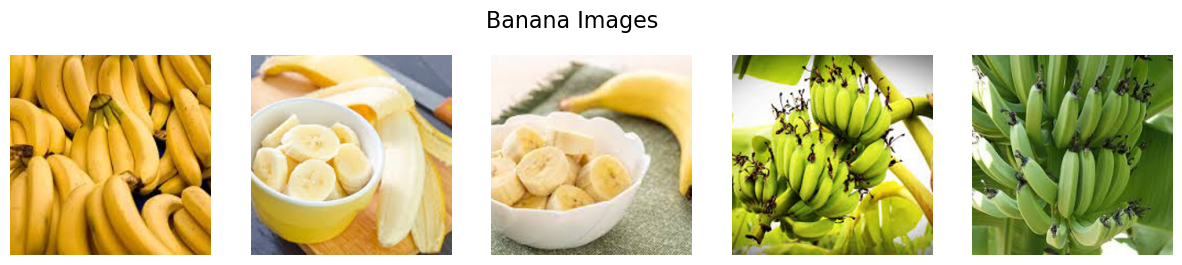

In [9]:
show_images(banana_resized_images, title="Banana Images", max_images=5)

We see that all the banans are recognizable in all images. So our work in this section is finished.

# Classifying the Images

We assign class 0 to apples and class 1 to banans:

In [10]:
xs = np.array(apple_images + banana_resized_images)
ys = np.array([0] * len(apple_images) + [1] * len(banana_resized_images))

Then, we randomly suffle the dataset:

In [11]:
indices = list(range(len(xs)))
np.random.shuffle(indices)
xs = xs[indices]
ys = ys[indices]

In [12]:
xs.shape

(62, 256, 256, 3)

In [13]:
ys.shape

(62,)

We make sure the correctness of the suffling process by plotting the data again:

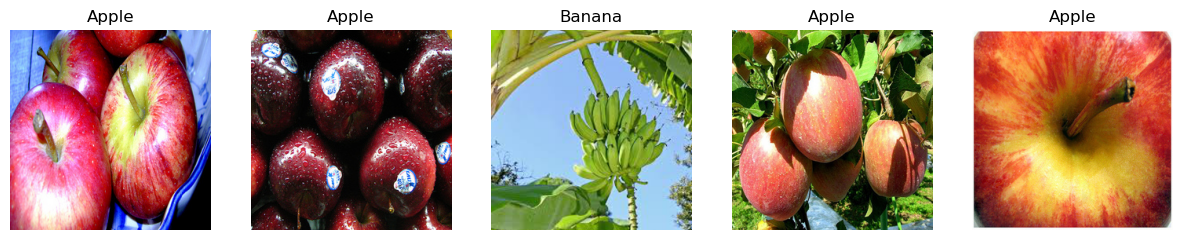

In [14]:
label_names = ['Apple' if y == 0 else 'Banana' for y in ys]
show_images(xs[5:10], label_names[5:10])

### Method 1: Using thresholding per channel

In this method we compute the average values of each channel in the image, and then use a threshold to classify it.

To do this, we implement the `channel_prediction` function, which takes 4 arguments:
- xs: the images
- channel: the channel on which we apply thresholding
- thresh: the threshold value
- target_class: the class to which the sample is assigned if the average value is bigger than the threshold

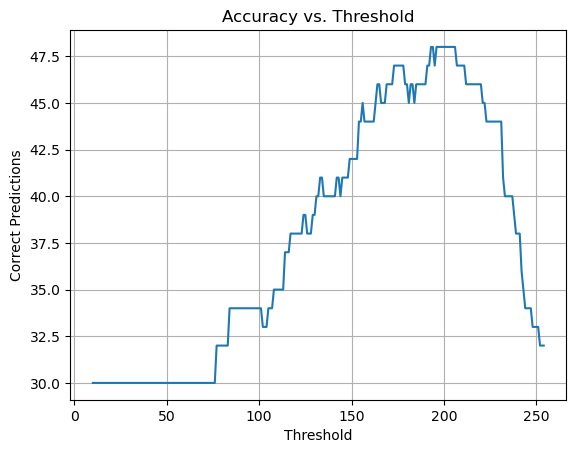

Best threshold: 193
Accuracy: 0.7741935483870968


In [15]:
best_thresh, acc = find_best_threshold(xs, ys, channel=0, target_class=1, thresh_range=(10, 255))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

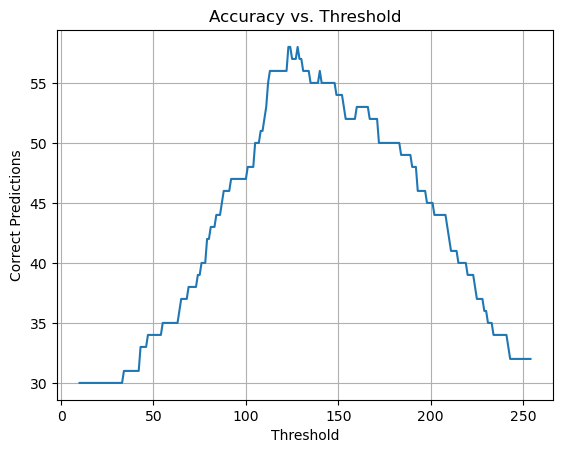

Best threshold: 123
Accuracy: 0.9354838709677419


In [16]:
best_thresh, acc = find_best_threshold(xs, ys, channel=1, target_class=1, thresh_range=(10, 255))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

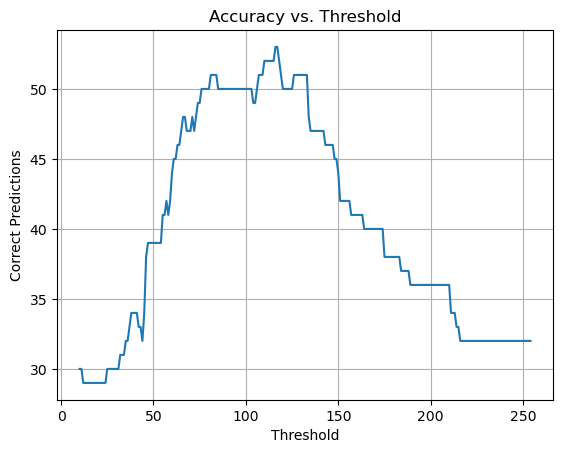

Best threshold: 116
Accuracy: 0.8548387096774194


In [17]:
best_thresh, acc = find_best_threshold(xs, ys, channel=2, target_class=1, thresh_range=(10, 255))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

### Method 2: Using channel to channel ratio

In this method we compute the ratio between the average values of two channels in a single image, and then use a threshold to it.

To do this, we implement the `channel_to_channel_ratio_prediction` function, which takes 4 arguments:
- xs: the images
- channel1: the first channel
- channel2: the second channel
- thresh: the threshold value

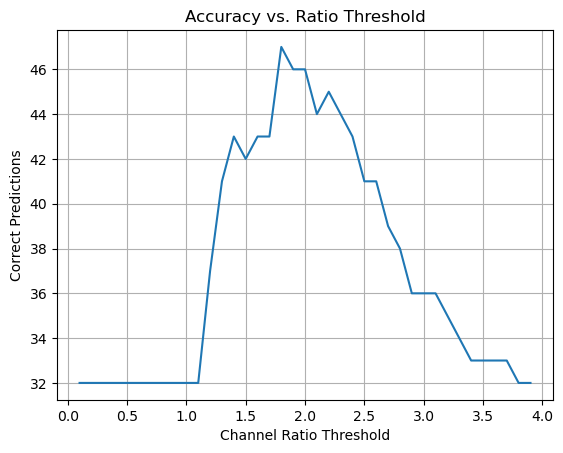

Best threshold: 1.8000000000000003
Accuracy: 0.7580645161290323


In [18]:
best_thresh, acc = find_best_ratio_thresh(xs, ys, channel1=0, channel2=2, threshold=(0.1, 4))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

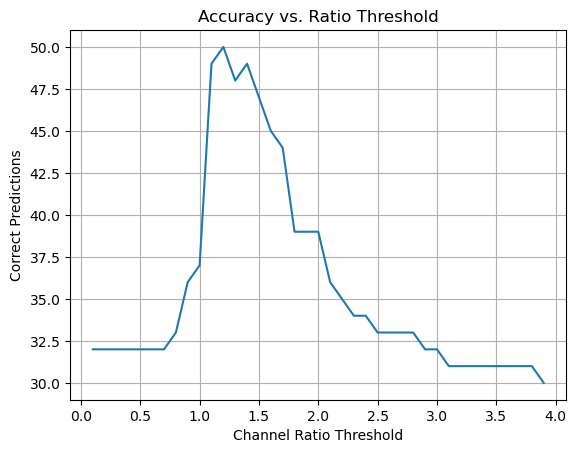

Best threshold: 1.2000000000000002
Accuracy: 0.8064516129032258


In [19]:
best_thresh, acc = find_best_ratio_thresh(xs, ys, channel1=0, channel2=1, threshold=(0.1, 4))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

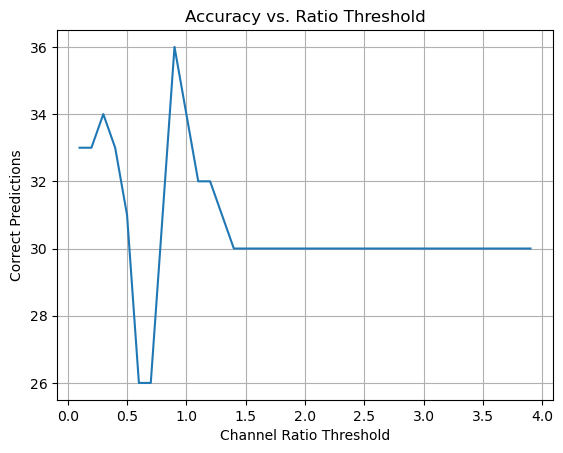

Best threshold: 0.9
Accuracy: 0.5806451612903226


In [20]:
best_thresh, acc = find_best_ratio_thresh(xs, ys, channel1=2, channel2=1, threshold=(0.1, 4))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

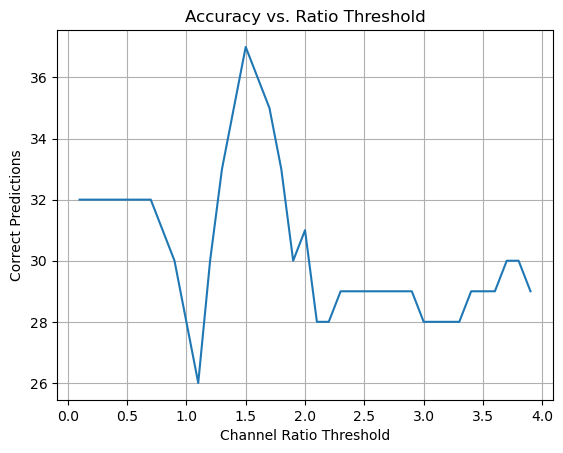

Best threshold: 1.5000000000000002
Accuracy: 0.5967741935483871


In [21]:
best_thresh, acc = find_best_ratio_thresh(xs, ys, channel1=1, channel2=2, threshold=(0.1, 4))
print("Best threshold:", best_thresh)
print("Accuracy:", acc)

___

# Evaluation

### Method 1

## Applying threshold on the red channel:

In [27]:
y_pred = channel_prediction(xs, channel=0, thresh=193, target_class=1)
metrics = calculate_metrics(ys, y_pred)

print(f"The accuracy is: {metrics["accuracy"]*100:.2f} \n")
print(f"Confusion Matrix: \n {metrics["confusion_matrix"]} \n")
print(f"The precision is: {metrics["precision"]*100:.2f} \n")
print(f"The recall is: {metrics["recall"]*100:.2f} \n")
print(f"The f1-score is: {metrics["f1_score"]*100:.2f} \n")


The accuracy is: 77.42 

Confusion Matrix: 
 [[29  3]
 [11 19]] 

The precision is: 86.36 

The recall is: 63.33 

The f1-score is: 73.08 



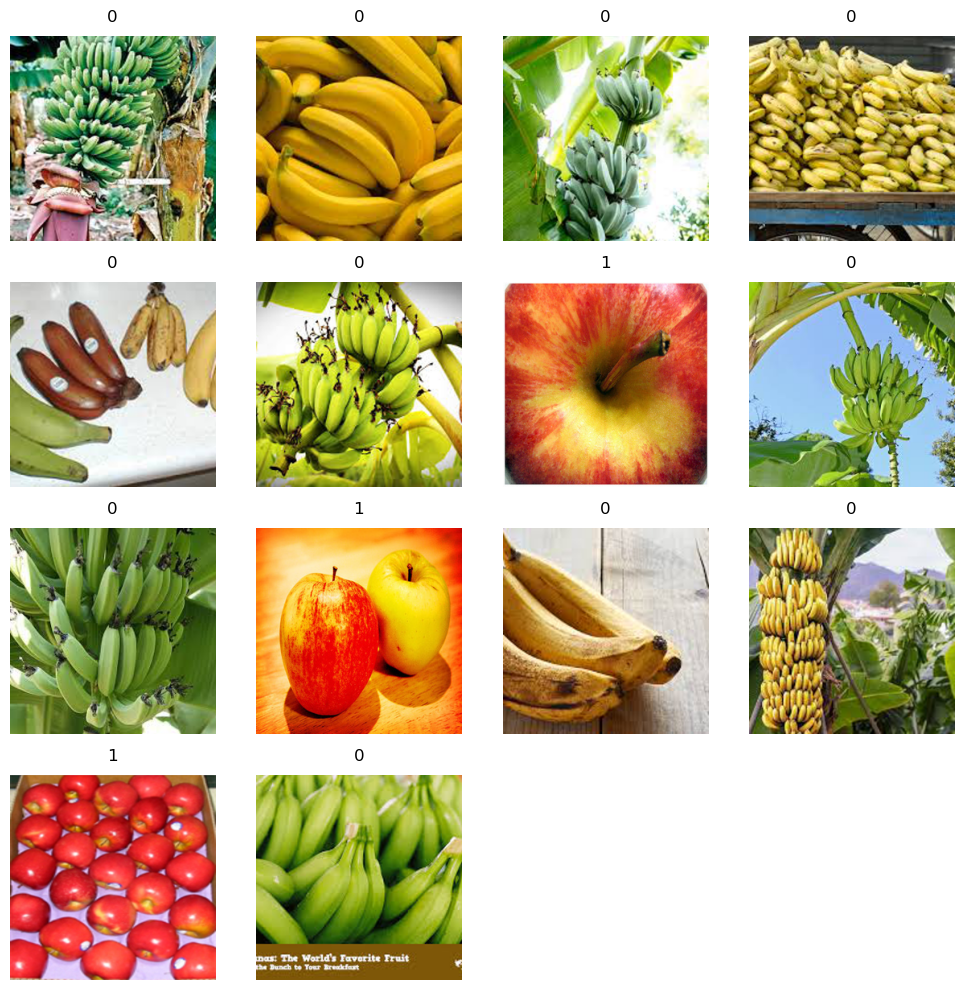

In [28]:
incorrect_xs = xs[y_pred != ys]
incorrect_ys = y_pred[y_pred != ys]
plot_random_images(len(incorrect_xs), incorrect_xs, incorrect_ys, figsize=(10, 10))

Problems of this classifier are as follows:
- Green Bananas do not have enough red component to exceed the threshold.
- Some red apples have red components bigger than the threshold.

## Applying threshold on the green channel:

In [29]:
y_pred = channel_prediction(xs, channel=1, thresh=123, target_class=1)
metrics = calculate_metrics(ys, y_pred)

print(f"The accuracy is: {metrics["accuracy"]*100:.2f} \n")
print(f"Confusion Matrix: \n {metrics["confusion_matrix"]} \n")
print(f"The precision is: {metrics["precision"]*100:.2f} \n")
print(f"The recall is: {metrics["recall"]*100:.2f} \n")
print(f"The f1-score is: {metrics["f1_score"]*100:.2f} \n")


The accuracy is: 93.55 

Confusion Matrix: 
 [[28  4]
 [ 0 30]] 

The precision is: 88.24 

The recall is: 100.00 

The f1-score is: 93.75 



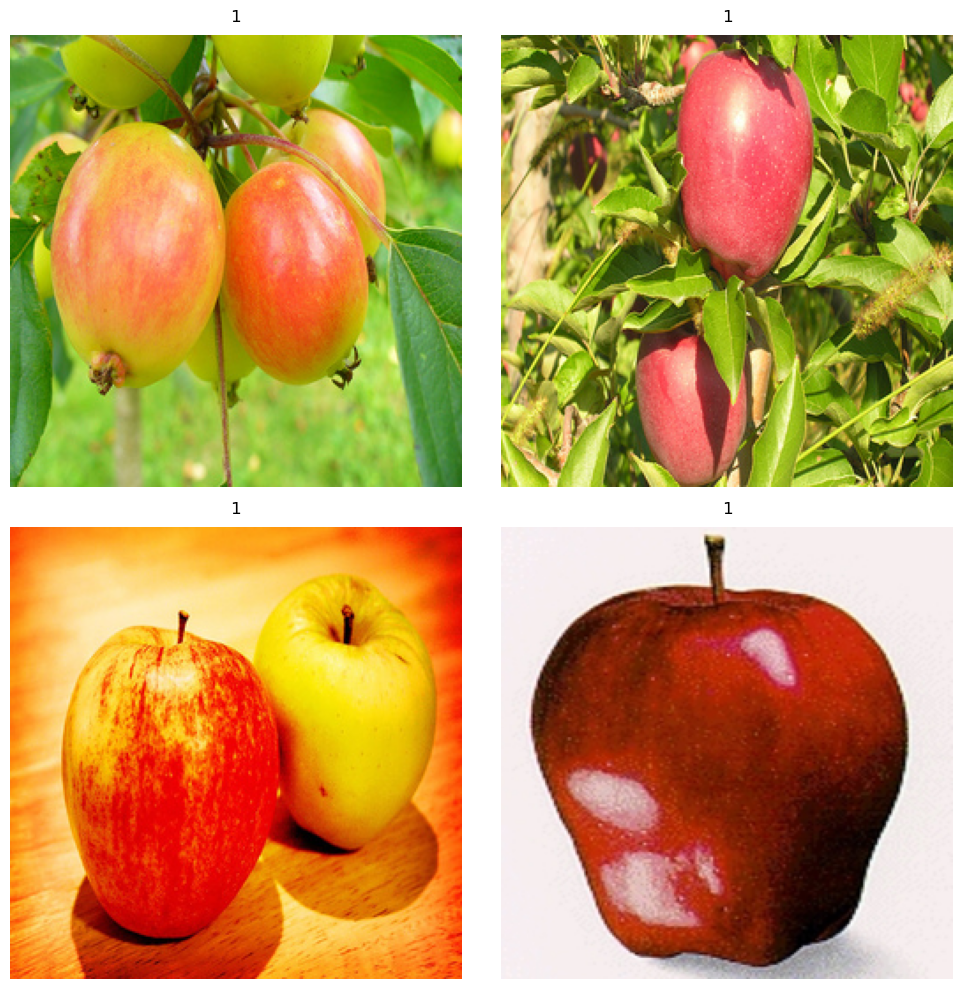

In [30]:
incorrect_xs = xs[y_pred != ys]
incorrect_ys = y_pred[y_pred != ys]
plot_random_images(len(incorrect_xs), incorrect_xs, incorrect_ys, figsize=(10, 10))

This is the best classifier out of all. The only problem with this classifiers are the apples with green components resulted by trees or the background.

## Applying threshold on the blue channel:

In [32]:
y_pred = channel_prediction(xs, channel=2, thresh=116, target_class=1)
metrics = calculate_metrics(ys, y_pred)

print(f"The accuracy is: {metrics["accuracy"]*100:.2f} \n")
print(f"Confusion Matrix: \n {metrics["confusion_matrix"]} \n")
print(f"The precision is: {metrics["precision"]*100:.2f} \n")
print(f"The recall is: {metrics["recall"]*100:.2f} \n")
print(f"The f1-score is: {metrics["f1_score"]*100:.2f} \n")


The accuracy is: 85.48 

Confusion Matrix: 
 [[31  1]
 [ 8 22]] 

The precision is: 95.65 

The recall is: 73.33 

The f1-score is: 83.02 



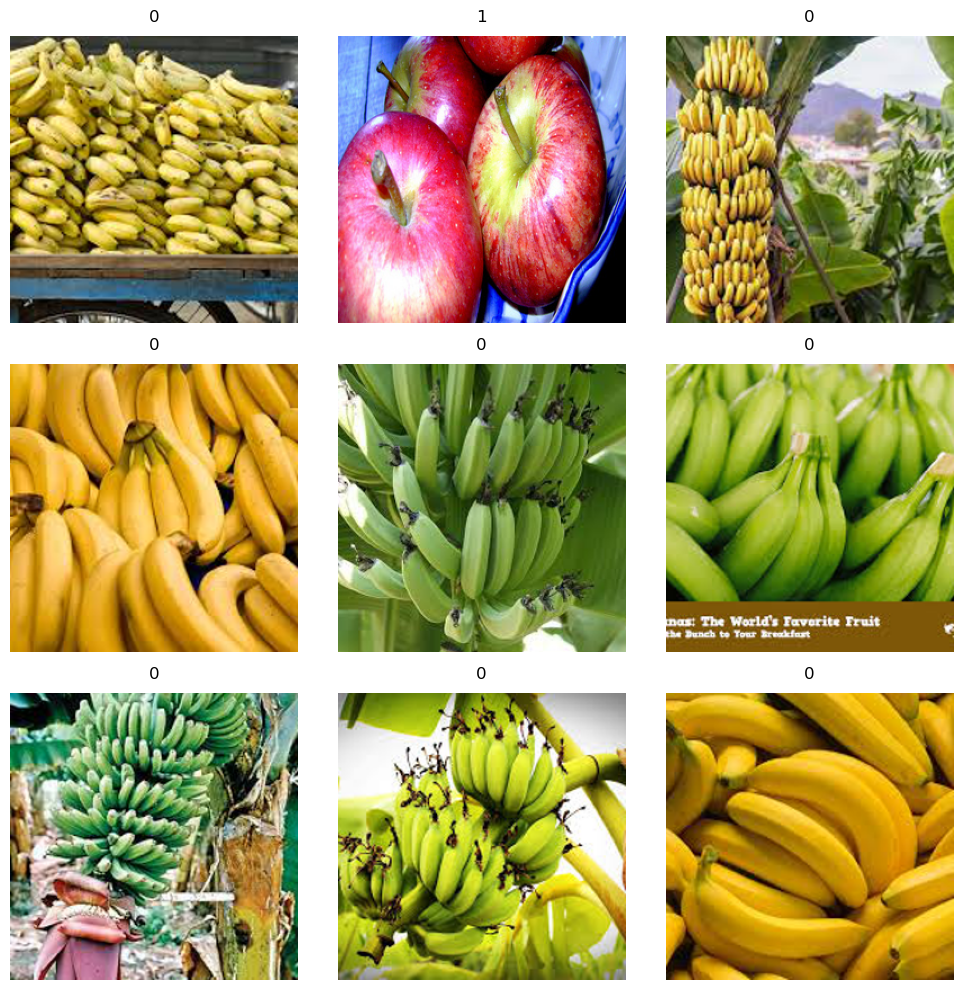

In [33]:
incorrect_xs = xs[y_pred != ys]
incorrect_ys = y_pred[y_pred != ys]
plot_random_images(len(incorrect_xs), incorrect_xs, incorrect_ys, figsize=(10, 10))

Problems of this classifier are as follows:
- Bananas that do not have enough blue component to exceed the threshold.
- An apple image has blue background resulting in misclassfiication.

___

### Method 2

### Applying threshold on the red to green ratio:

In [35]:
y_pred = channel_ratio_classifier(xs, channel1=0, channel2=1, thresh=1.2)
metrics = calculate_metrics(ys, y_pred)

print(f"The accuracy is: {metrics["accuracy"]*100:.2f} \n")
print(f"Confusion Matrix: \n {metrics["confusion_matrix"]} \n")
print(f"The precision is: {metrics["precision"]*100:.2f} \n")
print(f"The recall is: {metrics["recall"]*100:.2f} \n")
print(f"The f1-score is: {metrics["f1_score"]*100:.2f} \n")


The accuracy is: 80.65 

Confusion Matrix: 
 [[24  8]
 [ 4 26]] 

The precision is: 76.47 

The recall is: 86.67 

The f1-score is: 81.25 



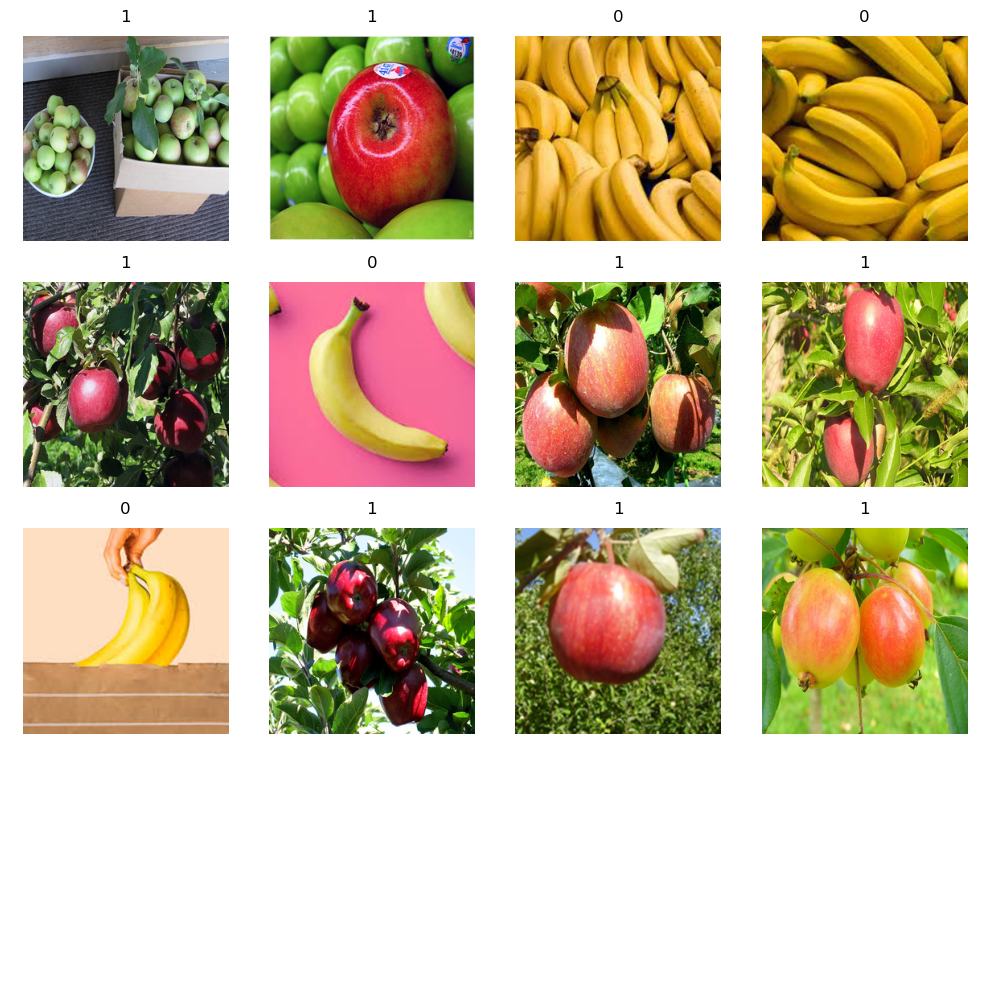

In [36]:
incorrect_xs = xs[y_pred != ys]
incorrect_ys = y_pred[y_pred != ys]
plot_random_images(len(incorrect_xs), incorrect_xs, incorrect_ys, figsize=(10, 10))

This is the best classfier in this method. Problems of this classifier are as follows:
- Green apples and the apples with noticable green background have low red:green ratio.
- Some bananas have high red:green ratios because of the background or the degree of yellow purity.

# Conclusion

In this experiment, we evaluated two naive approaches to solve a binary classification task on apples and bananas. Based on evaluations, calculating the average green color in each image and thresholding this value leads to the best results, where the classfier achieves an accuracy of 93.55% and a precision of 95.65%.

***